# Importing necessary libraries

In [1]:
# Import libraries

import torch
import numpy as np

import os
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats
from sklearn.metrics import mean_squared_error
from scipy.stats import bartlett
from scipy.stats import ttest_ind
from pathlib import Path

# Setting seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
cwd = os.getcwd()
cwd

'/home/dsml01/Ultron/Step3'

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
## load test dataset. We can use other dataset for comparison
# OVStest = pd.read_csv(str(Path(cwd).parents[0]) + '/Step1/Real Data/OVS1619_cleaned.csv')
# OVStest = pd.read_csv(str(Path(cwd).parents[0]) + '/Step1/Real Data/OVS1618_cleaned.csv')
# OVStest = pd.read_csv(str(Path(cwd).parents[0]) + '/Step1/Real Data/OVS2019_cleaned.csv')

# Load cleaned 2016-2018 OVS datasets; replace NAs by -1
OVStest = pd.read_csv(str(Path(cwd).parents[0]) + '/Step1/Real Data/OVS1618v5_-1.csv')

In [6]:
OVStest.shape ## 22070 rows and 259 columns

(66030, 293)

In [7]:
# Total of 24 Benchmark variables
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b13a_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [8]:
## continuous columns
with open(str(Path(cwd).parents[0]) + '/Step1/Real Data/continuous_columns.txt',"r+")   as f:
    con_cols = f.read().splitlines() 

## Load synthetic data generated by leading model

In [9]:
## list all continuous variables for which 0 is meaningful
column_list = ['b10','b11','b12number_1','b12number_2','b12number_3_5','b12number_4','b12number_6','b12number_7_8','c1c','c4c_1','b12b_1','b12b_2']

In [10]:
## clean synthethid data and test data
## replace NAs back and remove non-positive/positive values
def data_cleaning(df):
    df_new = df.copy()
    for expnd in con_cols:
        if expnd + '_cat' in df.columns:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd+'_cat'] == 1)
        if expnd in column_list:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd] < 0)
        else:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd] <= 0)
    return df_new

In [114]:
import sys
# USER INPUT IS REQUIRED
# pass the absolute path to CTGAN folder so that we can import DataTransformer in the next step.
# sys.path.append("/Users/stb/Documents/Synthetic Data Generation/CTGAN Work")
sys.path.append(str(Path(cwd).parents[0]) + "/CTGAN")

from ctgan import CTGANSynthesizer, TVAESynthesizer, TableganSynthesizer


# set seed - this is important as it needs to be the same seed as the one Optuna identified

torch.manual_seed(5)
np.random.seed(5)

temp_mdl = torch.load(str(Path(cwd).parents[0]) +
                      '/Step3/Model/tvae_model_34_PID5074_20210305_165149.pkl',
                      map_location=torch.device('cpu'))


In [115]:
# tvae_samples = temp_mdl.sample(OVStest.shape[0], condition_column=None, condition_value=None)
tvae_samples = temp_mdl.sample(10000, condition_column=None, condition_value=None)

tvae_samples.head()

,month,Mode of Transport (m1),a1,a4,a5,r.int1,r.int2,b1a,b1b,b2,b3b,b6,b7a,b7b,b7c,b7c_cat,b8,b9a,b9b,b9c,b9c_cat,b10,b11,b12_1,b12_2,b12_3,b12_4,b12_9,b12_10,b12_11,b12_12,b12_13,b12_14,b12_15,b12number_1,b12number_1_cat,b12number_2,b12number_2_cat,b12number_4,b12number_4_cat,b12number_6,b12number_6_cat,b13a_111,Main POV - Leisure/Holiday (b13a_112),b13a_113,Main POV - Visiting Friends/Family (b13a_114),b13a_115,Main POV - Business (b13a_116),Main POV - Healthcare (b13a_117),Main POV - Education/Training/Workshop (b13a_118),Main POV - Others (b13a_119),b13b_1,b13b_2,b13b_3,b13b_4,b13b_5,b13b_6,b13b_7,b13b_8,b13b_9,b13b_10,b13b_11,b13b_12,b13b_13,b13b_14,b13b_15,b13b_771,b13b_21,b13b_22,b13b_23,b13b_24,b13b_25,b13b_772,b13b_31,b13b_32,b13b_33,b13b_34,b13b_773,b13b_41,b13b_42,b13b_43,b13b_44,b13b_45,b13b_774,b13b_51,b13b_52,b13b_53,b13b_775,b13b_61,b13b_62,b13b_63,b13b_64,b13b_65,b13b_66,b13b_67,b13b_68,b13b_776,b13b_120,b13b_121,b13b_122,b13b_996,b13b_firstmention,b13b_secondmention,b13b_thirdmention,b13b_fourthmention,b13b_fifthmention,b13b_sixthmention,b13b_seventhmention,b13b_eighthmention,Travel Package (c1a),tr.type,c1c,c1c_cat,c2,c4a_1,c4a_2,c4a_3,"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)",c4a_4,c4a_5,c4a_6,c4a_7,c4a_8,"Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)",c4a_9,c4a_10,c4a_11,c4a_12,c4a_13,c4a_14,c4a_1mention,c4a_2mention,c4a_3mention,c4a_4mention,c4a_5mention,c4a_6mention,c4a_7mention,c4a_8mention,c4a_9mention,c4a_10mention,c4a_11mention,c4a_12mention,c4a_13mention,c4a_14mention,c4a_15mention,c4b_1,c4c_1,c4c_1_cat,c5,c5_cat,c6_1,c6_2,c6_3,c6_4,c6_5,c6_6,c6b_1_1,c6b_1_2,c6b_2_1,c6b_2_2,c6b_3_1,c6b_3_2,c6b_4_1,c6b_4_2,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)","Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",Expenditure on Casual Dining (c6c_2.r),Expenditure on Casual Dining (c6c_2.r)_cat,c6d,c6d_cat,c7a_1,c7a_2,c7b_1.r,c7b_1.r_cat,c7c,c7c_cat,c8b_2,c8b_4,c8b_8,c8b_10,c8b_1_4,c8b_1_7,c8b_1_8,c8b_1_9,c8b_1_10,c8b_3_1,c8b_3_2,c8b_3_3,c8b_3_4,c8b_3_5,c8b_3_6,c8b_3_8,c8b_3_9,c8b_3_10,c8b_5_5,c8b_11_4,c9,c10a_1,c10a_2,c10a_3,c10a_4,c10a_6,c10b_1_1,c10b_1_2,c10b_2_1,c10b_2_2,c10b_3_1,c10b_3_2,c10b_4_1,c10b_4_2,Expenditure on Sightseeing (c10c_1.r),Expenditure on Sightseeing (c10c_1.r)_cat,Expenditure on Attractions (c10c_2.r),Expenditure on Attractions (c10c_2.r)_cat,c10d,c10d_cat,c13_1,c13_2,c13_3,c13_5,c13_6,c13_8,c13_9,c13_10,c13_11,c13_12,c13_13,c13_14,c13_15,c13_21,c13_17,c13_19,c13_20,c13_22,c14.r,c14.r_cat,Expenditure on Fashion (t7.m.fash),Expenditure on Fashion (t7.m.fash)_cat,Expenditure on Healthcare & Wellness Products (t7.m.well),Expenditure on Healthcare & Wellness Products (t7.m.well)_cat,Expenditure on Confectionery & Food Items (t7.m.food),Expenditure on Confectionery & Food Items (t7.m.food)_cat,t7.m.gift,t7.m.gift_cat,t7.m.oth,t7.m.oth_cat,Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth),Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat,Expenditure on Shopping (t7.m.any),Expenditure on Shopping (t7.m.any)_cat,t7.fash,t7.well,t7.food,t7.gift,t7.oth,t7.any,c16,c16_cat,c17,f1,f2,f3,f4,f5,f7,hoteltier,Package Expenditure Per Person (c1b.r),Package Expenditure Per Person (c1b.r)_cat,b12b_1,b12b_1_cat,b12b_2,year,Expenditure on Accommodation (c4.tot.new),Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new),Expenditure on F&B (c6.tot.new)_cat,Expenditure on Transport (c7.tot.new),Expenditure on Transport (c7.tot.new)_cat,Expenditure on Sightseeing & Entertainment (c10.tot.new),Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat,a2.r.10l,f7a_n,b12number_3_5,b12number_3_5_cat,b12number_7_8,b12number_7_8_cat,c8b_99,c8b_1,c8b_3,c8b_5,c8b_6,c8b_7,c8b_11
0,11,1,1,57,43,34,6,2,1.0,1,1.0,2,NaN,NaN,0,1,2,NaN,3755.0,-1,1,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13.0,14.0,0.0,0.0,0.0,0,0

In [122]:
tvae_samples = pd.read_csv(cwd + '/Synthetic Data/tvae_model_34_PID5074_20210305_165149_sample.csv')
# tvae_samples = pd.read_csv('/Users/stb/Documents/Synthetic Data Generation/Training Trials/tvae/2019/20 modes eps 1e-3/kiv-tvae_PID21619/tvae_model_0_PID21619_20210828_012151_sample.csv')
tvae_samples_cleaned = data_cleaning(tvae_samples)

In [123]:
tvae_samples_cleaned.shape

(9905, 293)

# 1. Visualization (KDE plots, Bar charts and Boxplots)

In [124]:
## KDE plots
def plots2(original_data, synthetic_data, list_expnd):
    
    for i in np.arange(len(list_expnd))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = list_expnd[i]
        col2 = list_expnd[i+1]
        prop1 =  round(sum(original_data[col1].isna())/len(original_data[col1])*100,2)
        ax[0].set_title(col1 + " " + str(prop1) +'% NAs')
              
        sns.kdeplot(original_data[col1],shade=True, ax=ax[0], label='OVS')
        if len(synthetic_data[col1].unique()) > 1:
            sns.kdeplot(synthetic_data[col1],shade=True,ax=ax[0], label='Synthetic')
        ax[0].legend();
        prop2 =  round(sum(original_data[col2].isna())/len(original_data[col2])*100,2)
        ax[1].set_title(col2 + " " + str(prop2) +'% NAs')
              
        sns.kdeplot(original_data[col2],shade=True, ax=ax[1], label='OVS')
        if len(synthetic_data[col2].unique()) > 1:
            sns.kdeplot(synthetic_data[col2],shade=True,ax=ax[1], label='Synthetic')
        ax[1].legend();
        plt.show()

In [125]:
## Bar plots
def plots2_bar(original_data, synthetic_data, cat_cols):
    width = 0.1
    
    for i in np.arange(len(cat_cols))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = cat_cols[i]
        col2 = cat_cols[i+1]
        xlab1 = np.asarray(original_data[col1].value_counts().index)
        ax[0].set_title(col1)
        ax[0].bar(xlab1,original_data[col1].value_counts(normalize=True), color='g', label='OVS',width=width)
        ax[0].bar(xlab1+width,synthetic_data[col1].value_counts(normalize=True), color='b', label='Synthetic Data',width=width)        
        ax[0].legend();
        xlab2 = np.asarray(original_data[col2].value_counts().index)
        ax[1].set_title(col2)
        ax[1].bar(xlab2,original_data[col2].value_counts(normalize=True), color='g', label='OVS',width=width)
        ax[1].bar(xlab2+width,synthetic_data[col2].value_counts(normalize=True), color='b', label='Synthetic Data',width=width)        
        ax[1].legend();
        plt.show()

In [126]:
# boxplot
def boxplots2(original_data, synthetic_data, list_expnd):
    
    for i in np.arange(len(list_expnd))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = list_expnd[i]
        col2 = list_expnd[i+1]
        prop1 = round(sum(original_data[col1].isna())/len(original_data[col1])*100,2)
        ax[0].set_title(col1 + " " + str(prop1) +'% NAs')
        df1 = pd.DataFrame({'OVS': original_data[col1],
                           'Synthetic Data':synthetic_data[col1]})
        sns.boxplot(x="variable", y="value", data=pd.melt(df1),ax=ax[0],showmeans=True, meanprops={"marker":"s",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black"})

        prop2 = round(sum(original_data[col2].isna())/len(original_data[col2])*100,2)
        ax[1].set_title(col2 + " " + str(prop2) +'% NAs')
              
        df2 = pd.DataFrame({'OVS': original_data[col2],
                           'Synthetic Data': synthetic_data[col2]})
        sns.boxplot(x="variable", y="value", data=pd.melt(df2),ax=ax[1],showmeans=True,meanprops={"marker":"s",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black"})
        plt.show()

## 1.1 KDE plots for OVS2019 vs Synthetic data under leading model (continuous benchmark variables)

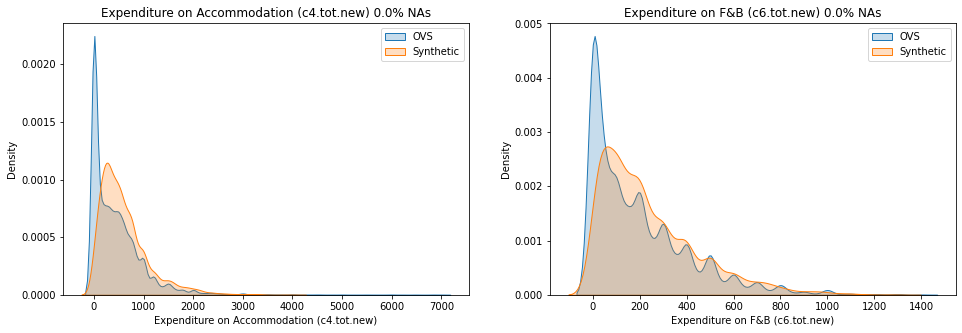

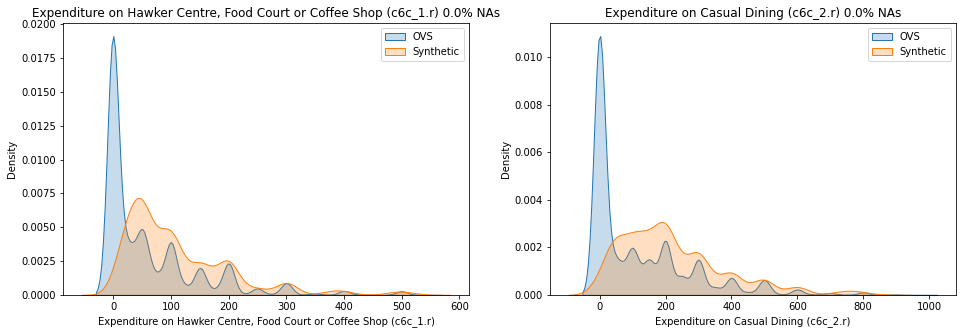

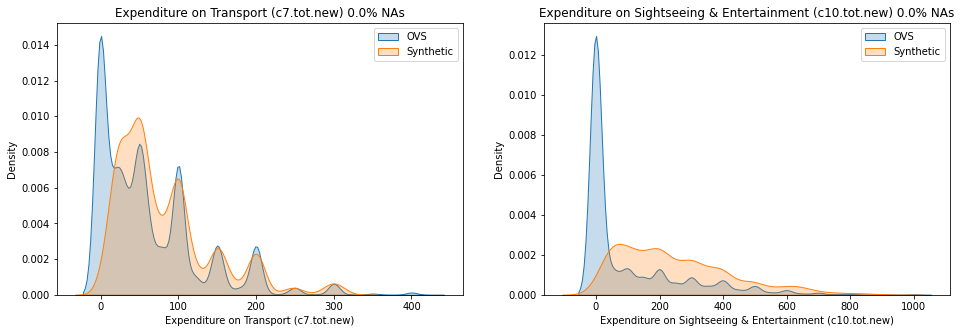

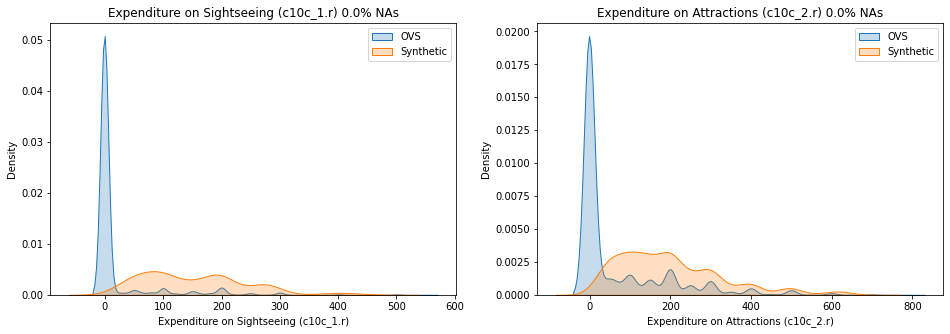

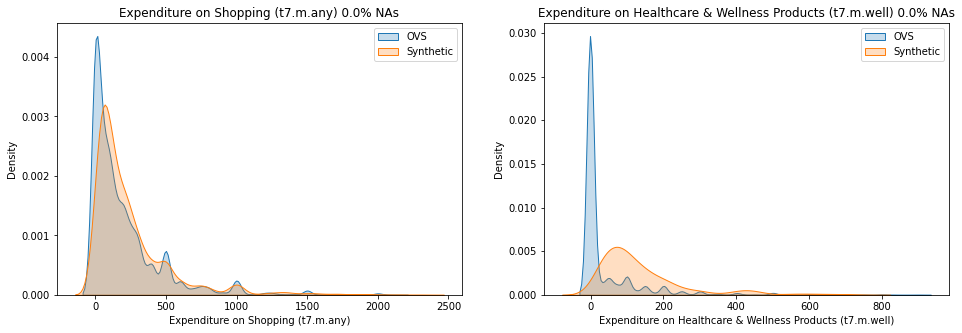

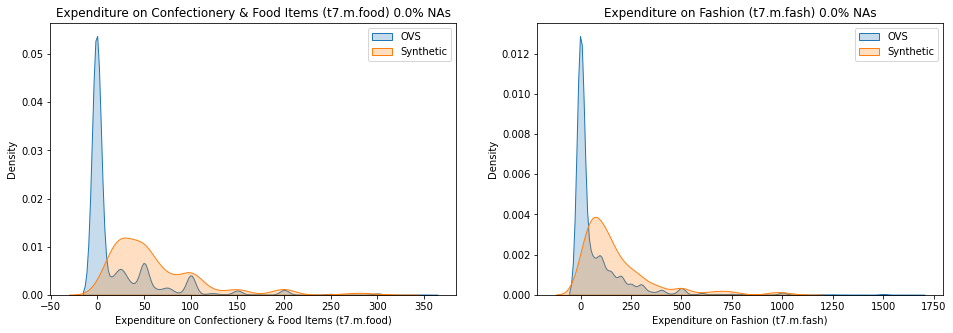

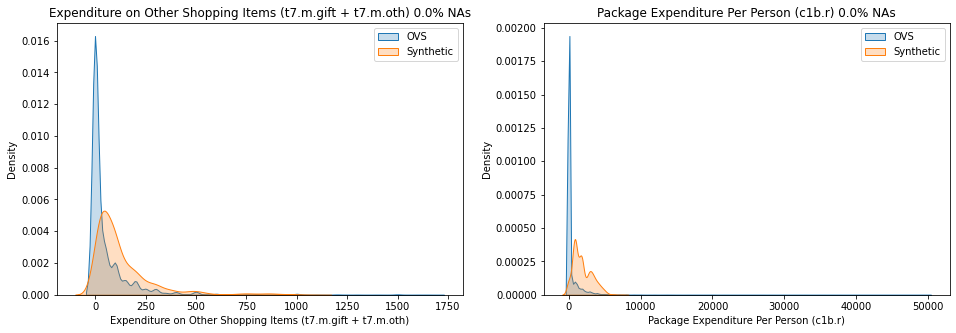

In [127]:
plots2(OVStest,tvae_samples_cleaned,list_expnd)

## 1.2 Boxplots for OVS2019 vs Synthetic data under leading model (continuous benchmark variables)

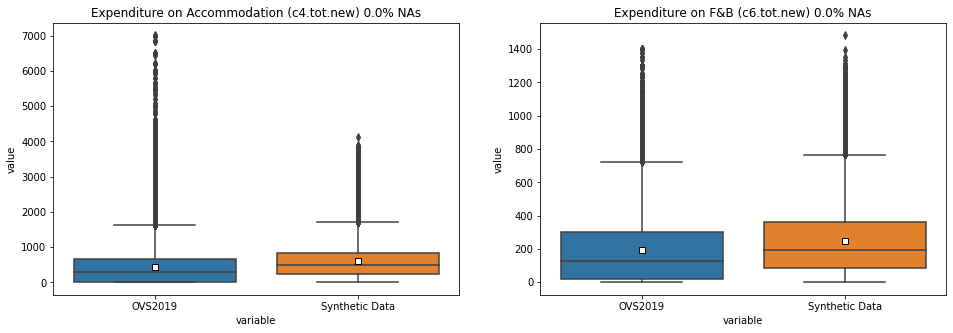

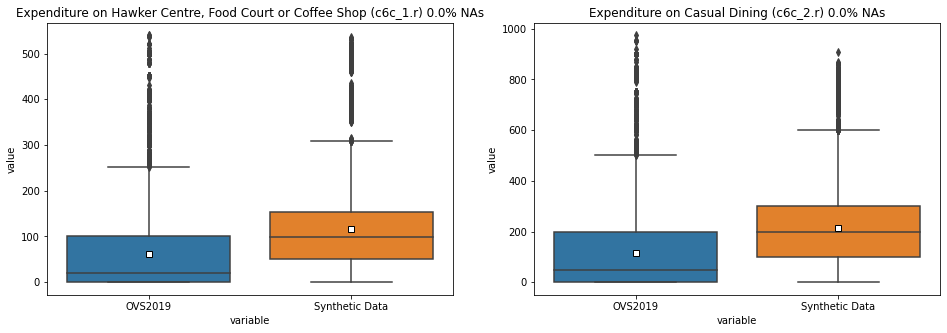

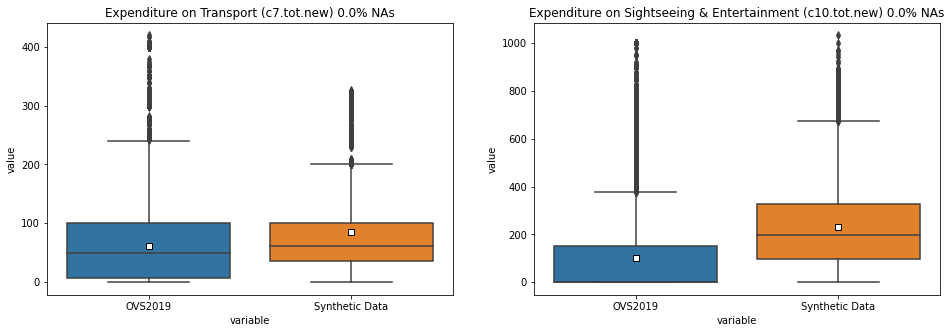

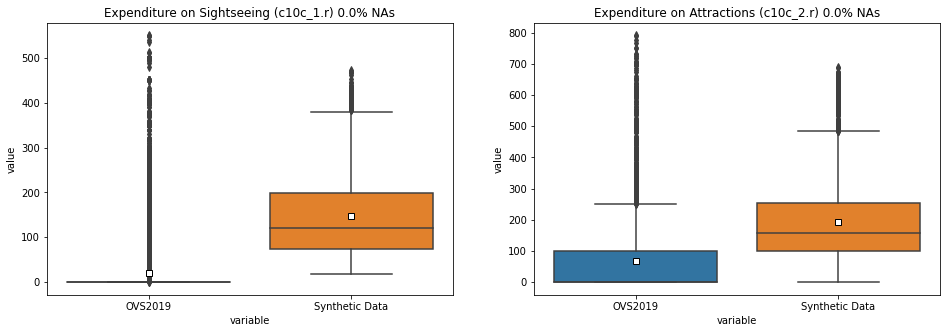

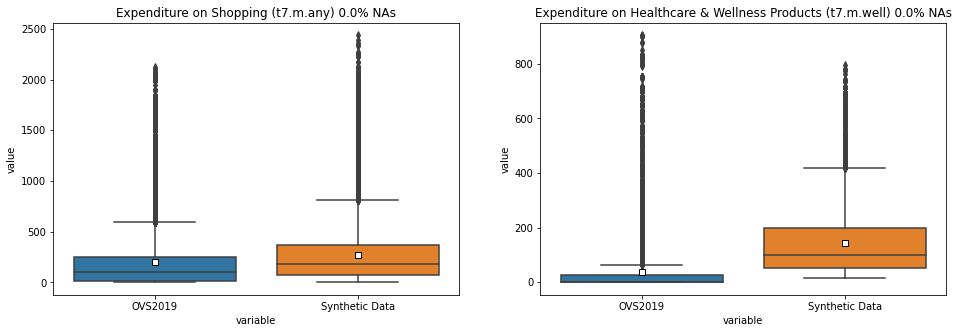

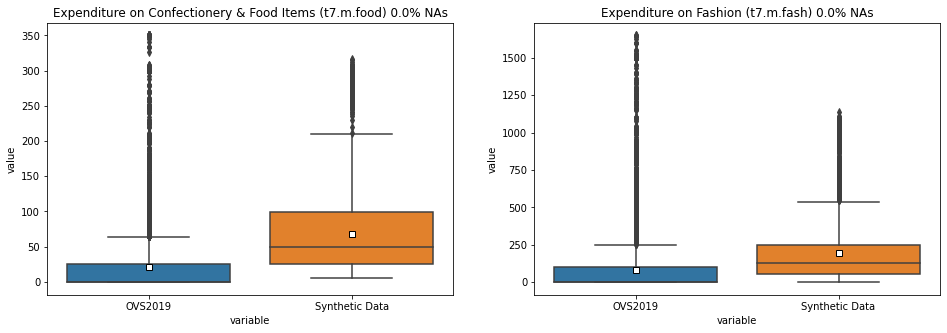

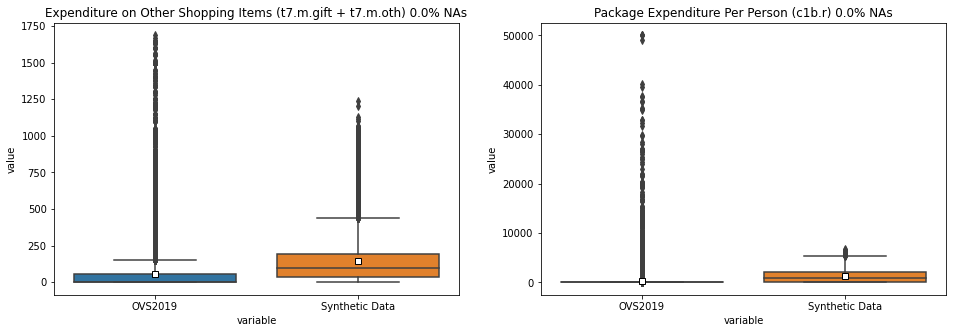

In [71]:
boxplots2(OVStest,tvae_samples_cleaned,list_expnd)

## 1.3 Bar charts for OVS2019 vs Synthetic data under leading model (categorical benchmark variables)¶

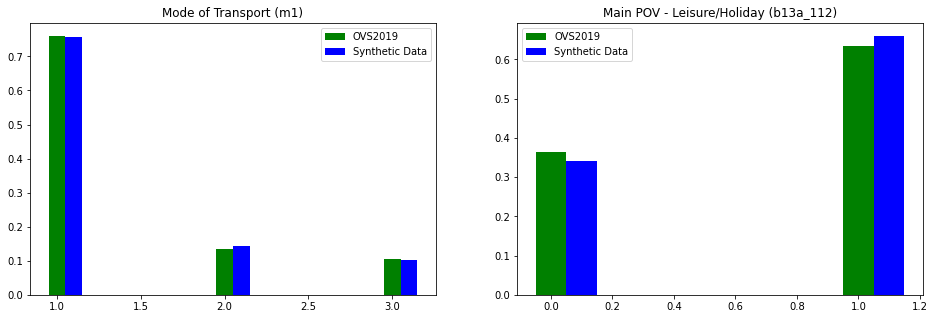

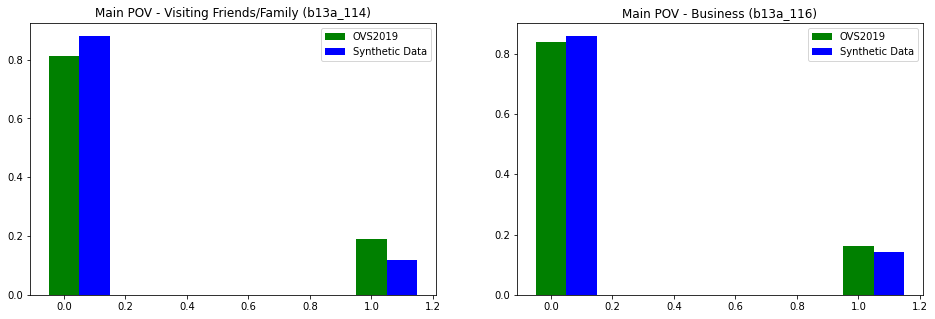

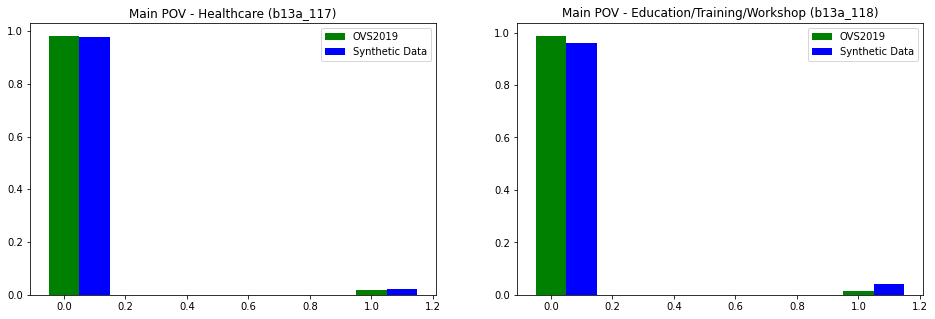

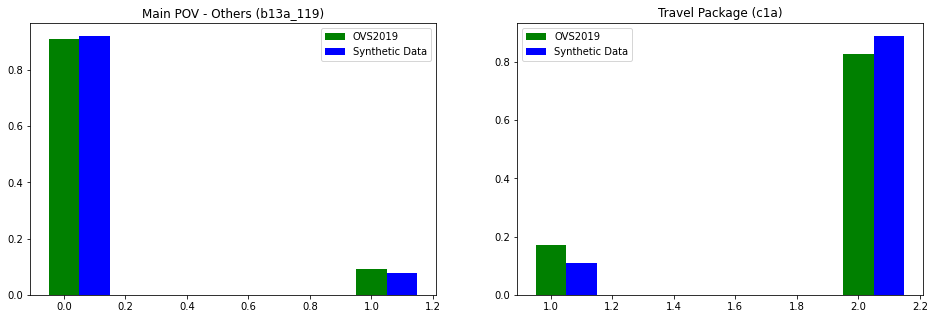

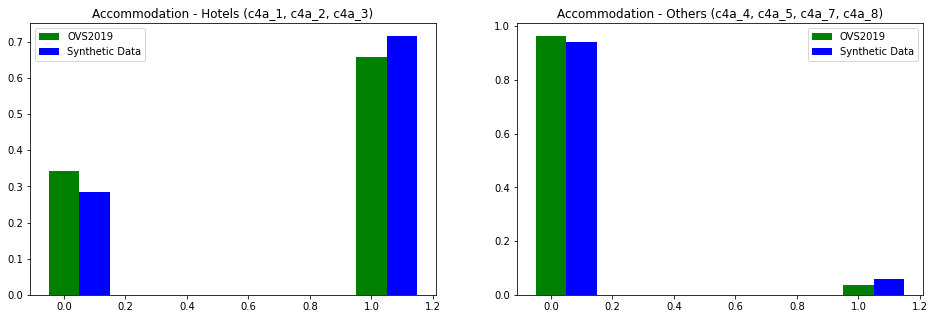

In [72]:
plots2_bar(OVStest,tvae_samples_cleaned,list_cat)

# 2. Compute statistics

In [73]:
# Compute statistics for continuous benchmarks
def continuous_statistics(df, list_cols):
    result_df = df[list_cols].describe()
    result_df = result_df.transpose()
    result_df['count'] = result_df['count'].astype(int)
        
    # Compute the standard error of the mean
    result_df.insert(loc = 2, column = 'Standard Error', value = df[list_cols].sem())
    
    # Compute 95% Confidence Interval (assuming normal distribution)
    result_df.loc[:,'Lower 95% CI'], result_df.loc[:,'Upper 95% CI'] = stats.norm.interval(0.95, loc=result_df.loc[:,'mean'], scale=result_df.loc[:,'Standard Error'])
    
    result_df.rename(columns = {'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation', '50%': 'Median'}, inplace=True)
    return result_df

In [74]:
# Compute statistics for categorical benchmarks
def categorical_statistics(df, list_cols):
    result_df = df[list_cols].melt(var_name='Variable', value_name='Value').groupby(['Variable', 'Value']).size().to_frame(name='Count')
    result_df['Proportion'] = result_df['Count'].div(result_df['Count'].sum(level=0), level=0)
    result_df['np>5'] = (result_df['Count'] * result_df['Proportion']) > 5
    result_df['nq>5'] = (result_df['Count'] * (1 - result_df['Proportion'])) > 5
    result_df['Standard Error'] = np.sqrt(result_df['Proportion'] * (1-result_df['Proportion']) / result_df['Count'].sum(level=0))
    result_df['Lower 95% CI'] = result_df['Proportion'] - 1.96 * result_df['Standard Error']
    result_df['Upper 95% CI'] = result_df['Proportion'] + 1.96 * result_df['Standard Error']
    return result_df

In [75]:
syn_cat_stat = categorical_statistics(tvae_samples_cleaned,list_cat)
syn_con_stat = continuous_statistics(tvae_samples_cleaned,list_expnd)

In [76]:
real_cat_stat = categorical_statistics(OVStest,list_cat)
real_con_stat = continuous_statistics(OVStest,list_expnd)

In [77]:
con_stat_df =  pd.DataFrame({'Real Mean': real_con_stat['Mean'],
                   'Synthetic Mean':syn_con_stat['Mean'],
                   'Absolute Difference':abs(real_con_stat['Mean']-syn_con_stat['Mean']),
                        'Real Std': real_con_stat['Standard Deviation'],
                        'Synthetic Std': syn_con_stat['Standard Deviation']})

## 2.1 Compare mean and standard deviation for continuous variables

In [78]:
con_stat_df

,Real Mean,Synthetic Mean,Absolute Difference,Real Std,Synthetic Std
Expenditure on Accommodation (c4.tot.new),435.044752,620.769864,185.725111,538.704690,541.267983
Expenditure on F&B (c6.tot.new),194.530211,245.034791,50.504580,212.677285,218.163616
"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",60.448591,116.025548,55.576957,89.684666,99.400172
Expenditure on Casual Dining (c6c_2.r),116.853155,215.358379,98.505224,158.157116,164.069999
Expenditure on Transport (c7.tot.new),61.695835,84.975946,23.280111,67.416126,65.827594
Expenditure on Sightseeing & Entertainment (c10.tot.new),101.644401,230.015226,128.370824,166.940561,177.894192
Expenditure on Sightseeing (c10c_1.r),19.674784,146.239230,126.564446,61.837520,95.520534
Expenditure on Attractions (c10c_2.r),67.846268,193.079528,125.233260,121.381199,136.367995
Expenditure on Shopping (t7.m.any),200.114378,271.155691,71.041313,270.526414,306.956106
Expenditure on Healthcare & Wellness Products (t7.m.well),36.797430,142.234178,105.436748,90.945866,127.458458


## 2.2 Compare proportions for categorical variables

In [79]:
cat_stat_df =  pd.DataFrame({'Real Proportion': real_cat_stat['Proportion'],
                   'Synthetic Proportion':syn_cat_stat['Proportion'],
                   'Absolute Difference':abs(real_cat_stat['Proportion']-syn_cat_stat['Proportion'])})

In [80]:
cat_stat_df

Real Proportion  \
Variable                                           Value                    
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0             0.341920   
                                                   1             0.658080   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0             0.963244   
                                                   1             0.036756   
Main POV - Business (b13a_116)                     0             0.838422   
                                                   1             0.161578   
Main POV - Education/Training/Workshop (b13a_118)  0             0.987127   
                                                   1             0.012873   
Main POV - Healthcare (b13a_117)                   0             0.981190   
                                                   1             0.018810   
Main POV - Leisure/Holiday (b13a_112)              0             0.364728   
                                                   1             0.635272   
Main POV - Others (b13a_119)                       0             0.909011   
                                                   1             0.090989   
Main POV - Visiting Friends/Family (b13a_114)      0             0.811131   
                                                   1             0.188869   
Mode of Transport (m1)                             1             0.760215   
                                                   2             0.133939   
                                                   3             0.105846   
Travel Package (c1a)                               1             0.171664   
                                                   2             0.828336   

                                                          Synthetic Proportion  \
Variable                                           Value                         
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0                  0.283583   
                                                   1                  0.716417   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0                  0.942556   
                                                   1                  0.057444   
Main POV - Business (b13a_116)                     0                  0.858685   
                                                   1                  0.141315   
Main POV - Education/Training/Workshop (b13a_118)  0                  0.958852   
                                                   1                  0.041148   
Main POV - Healthcare (b13a_117)                   0                  0.976193   
                                                   1                  0.023807   
Main POV - Leisure/Holiday (b13a_112)              0                  0.340194   
                                                   1                  0.659806   
Main POV - Others (b13a_119)                       0                  0.920733   
                                                   1                  0.079267   
Main POV - Visiting Friends/Family (b13a_114)      0                  0.880706   
                                                   1                  0.119294   
Mode of Transport (m1)                             1                  0.756293   
                                                   2                  0.141966   
                                                   3                  0.101742   
Travel Package (c1a)                               1                  0.110889   
                                                   2                  0.889111   

                                                          Absolute Difference  
Variable                                           Value                       
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0                 0.058337  
                                                   1                 0.058337  
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0                 0.020688  

## 2.3 Compare coefficient of variation

In [81]:
def COV(data:pd.DataFrame,list_expnd=tuple()):
    result_list = []
    for col in list_expnd:
        result_list.append(data[col]._get_numeric_data().std()/data[col]._get_numeric_data().mean())
    return result_list

In [82]:
COV_df = pd.DataFrame({'Variable':list_expnd,
                      'Real COV':COV(OVStest,list_expnd),
                      'Synthetic COV': COV(tvae_samples_cleaned,list_expnd)})

In [83]:
COV_df

,Variable,Real COV,Synthetic COV
0,Expenditure on Accommodation (c4.tot.new),1.238274,0.871930
1,Expenditure on F&B (c6.tot.new),1.093287,0.890337
2,"Expenditure on Hawker Centre, Food Court or Co...",1.483652,0.856709
3,Expenditure on Casual Dining (c6c_2.r),1.353469,0.761846
4,Expenditure on Transport (c7.tot.new),1.092718,0.774662
5,Expenditure on Sightseeing & Entertainment (c1...,1.642398,0.773402
6,Expenditure on Sightseeing (c10c_1.r),3.142983,0.653180
7,Expenditure on Attractions (c10c_2.r),1.789062,0.706279
8,Expenditure on Shopping (t7.m.any),1.351859,1.132029
9,Expenditure on Healthcare & Wellness Products ...,2.471528,0.896117


## 2.4 Calculate KLD values

In [84]:
def discrete_probs(column, unique_list):
    # find probability in the order of unique_list
    column = pd.Series(column)
    counts = column.value_counts()
    probs = []
    total_length = len(column)
    for i in unique_list:
        val = 0
        if i in counts.index:
            val = counts[i]
        probs.append(val/total_length)

    return np.array(probs)

# KL-divergence formula
def kl_divergence(p, q):
    p[p < 1e-12] = 1e-12
    q[q < 1e-12] = 1e-12
    a = np.log(p)
    b = np.log(q)
    return np.sum(p * (a - b))

###For continuous variables:
def ecdf(x):
    x = np.sort(x)
    u, c = np.unique(x, return_counts=True) 
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n 
    def interpolate_(x_): 
        yinterp = np.interp(x_, u, y, left=0.0, right=1.0)
        return yinterp
    return interpolate_
def cumulative_continuous_kl(x,y,fraction=0.5):
    dx = np.diff(np.sort(np.unique(x))) 
    dy = np.diff(np.sort(np.unique(y)))
    ex = np.min(dx)
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction 
    n = len(x)
    P = ecdf(x)
    Q = ecdf(y)
    p = P(x) - P(x-e)
    q = Q(x) - Q(x-e)
    p[p < 1e-12] = 1e-12
    q[q < 1e-12] = 1e-12
    KL = abs((1./n)*np.sum(np.log(p/q))-1) 
    return KL

In [85]:
def KLD(real, fake, discrete_columns):
    KLD = []
    for column in fake.columns:
        column_fake = fake[column].dropna().values
        column_real = real[column].dropna().values
        if column in discrete_columns:
            # find list of all unique values
            unique_list = []
            arrs = [np.unique(column_fake), np.unique(column_real)]
            for arr in arrs:
                for val in arr:
                    if val not in unique_list:
                        unique_list.append(val)
            # find probabilities of values according to order in unique_list
            fake_prob = discrete_probs(column_fake, unique_list)
            real_prob = discrete_probs(column_real, unique_list)
            KLD.append((kl_divergence(fake_prob, real_prob)+kl_divergence(real_prob,fake_prob)/2))
        else:
            # check whether indicator columns exist
            if column + '_cat' in fake.columns:
                column_fake = column_fake[fake[column + '_cat'] == 0]
                column_real = column_real[real[column + '_cat'] == 0]
                ## list all continuous variables for which 0 is meaningful
                column_list = ['b10','b11','b12number_1','b12number_2','b12number_3_5',
                               'b12number_4','b12number_6','b12number_7_8','c1c','c4c_1','b12b_1','b12b_2']
                if column in column_list:
                    column_fake = column_fake[column_fake >= 0]
                    column_real = column_real[column_real >= 0]
                else:
                    column_fake = column_fake[column_fake > 0]
                    column_real = column_real[column_real > 0]
                if len(column_fake) >= 1000 and len(column_real) >= 1000:
                    KLD.append((cumulative_continuous_kl(column_fake, column_real)+cumulative_continuous_kl(column_real, column_fake))/2)
                else:
                    KLD.append(np.nan)
            else:
                KLD.append((cumulative_continuous_kl(column_fake, column_real)+cumulative_continuous_kl(column_real, column_fake))/2)
    return np.array(KLD)

In [86]:
kld = pd.DataFrame({'Variable':list_expnd+list_cat})
kld['KLD value'] = np.round_(KLD(OVStest[list_expnd+list_cat], tvae_samples_cleaned[list_expnd+list_cat], list_cat),4)

In [87]:
kld

,Variable,KLD value
0,Expenditure on Accommodation (c4.tot.new),5.5291
1,Expenditure on F&B (c6.tot.new),5.3057
2,"Expenditure on Hawker Centre, Food Court or Co...",8.2163
3,Expenditure on Casual Dining (c6c_2.r),8.5874
4,Expenditure on Transport (c7.tot.new),5.0385
5,Expenditure on Sightseeing & Entertainment (c1...,9.8918
6,Expenditure on Sightseeing (c10c_1.r),13.8590
7,Expenditure on Attractions (c10c_2.r),10.6621
8,Expenditure on Shopping (t7.m.any),4.8041
9,Expenditure on Healthcare & Wellness Products ...,11.8232


## 2.5 Check overlapping of 95% CI

In [88]:
cmap = plt.get_cmap("tab10")

In [89]:
import copy
def plot_CI(real: pd.DataFrame, fake: pd.DataFrame, cont=True):
    col =  plt.get_cmap("tab10")

    if cont:
        for i in np.arange(real.shape[0])[::2]:
            fig,ax = plt.subplots(1, 2, figsize=(12, 1))
            for k in np.arange(2): 
                    ax[k].set_ylim([0.9,1.7])
                    ax[k].set_title(real.index[i+k],fontsize=10)
                    ax[k].errorbar(x=real['Mean'].values[i+k], y=1, xerr=1.96*real['Standard Error'].values[i+k],fmt='D', color='g',label='Real Data')
                    ax[k].axvline(x=real['Lower 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].axvline(x=real['Upper 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].errorbar(x=fake['Mean'].values[i+k],y=1+0.1, xerr=1.96*fake['Standard Error'].values[i+k], fmt='o',alpha=.3, label='Synthetic Data')
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(handles,labels,bbox_to_anchor=(1.05, 1.02, 1., .102), handlelength=2, loc='upper right',ncol=1, mode="expand", borderaxespad=0.)

    else:
        for i in np.arange(real.shape[0])[::3]:
            fig,ax = plt.subplots(1, 3, figsize=(14, 1))
            for k in np.arange(3):   
                    ax[k].set_ylim([0.9,1.7])
                    ax[k].set_title(real.index[i+k],fontsize=8)
                    ax[k].errorbar(x=real['Proportion'].values[i+k], y=1, xerr=1.96*real['Standard Error'].values[i+k],fmt='D', color='g',label='Real Data')
                    ax[k].axvline(x=real['Lower 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].axvline(x=real['Upper 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].errorbar(x=fake['Proportion'].values[i+k],y=1+0.1, xerr=1.96*fake['Standard Error'].values[i+k], fmt='o',alpha=.3, label='Synthetic Data')
        
        lines, labels = ax[2].get_legend_handles_labels()
        ax[2].legend(lines,labels,bbox_to_anchor=(1.05, 1.02, 1., .102),handlelength=4,loc='upper right',ncol=1, mode="expand", borderaxespad=0.)

    plt.show()

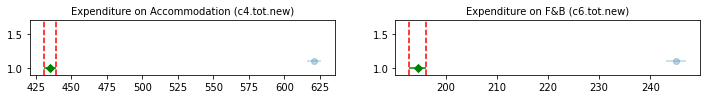

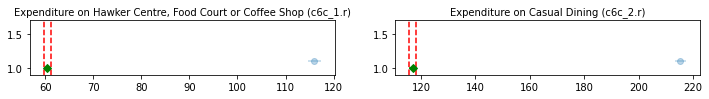

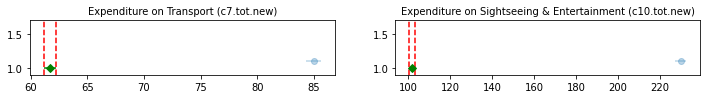

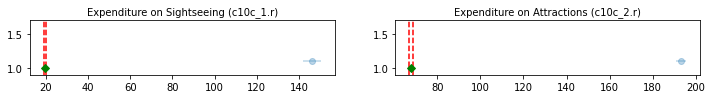

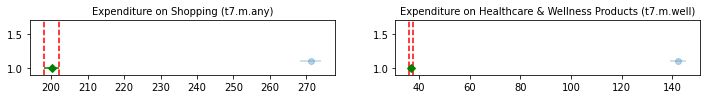

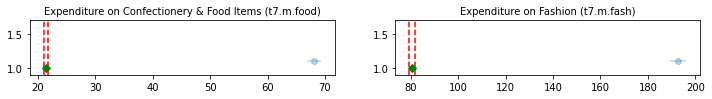

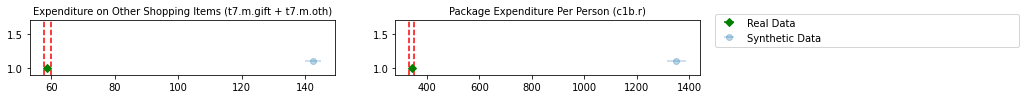

In [90]:
# Continuous variables
plot_CI(real_con_stat,fake = syn_con_stat,cont=True)

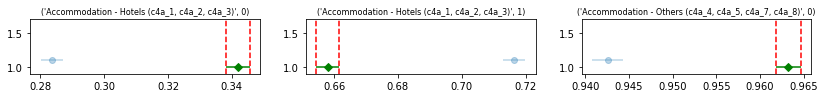

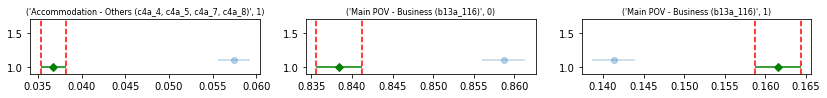

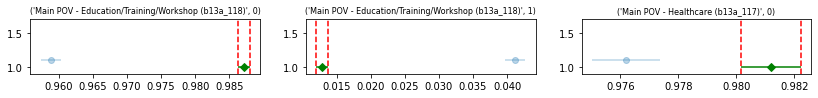

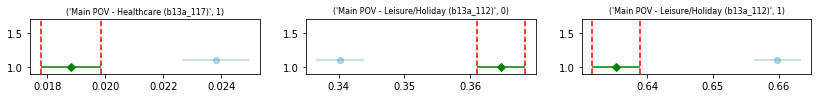

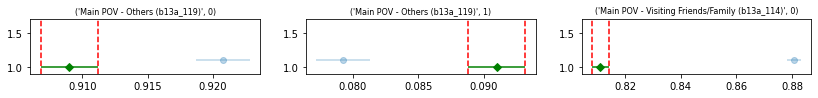

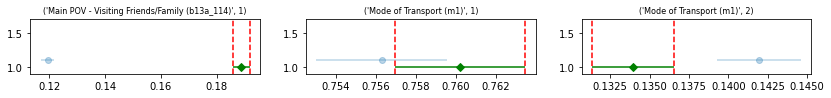

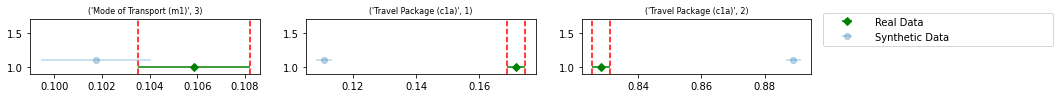

In [91]:
# categorical variables
plot_CI(real_cat_stat,fake = syn_cat_stat,cont=False)

In [92]:
def check_overlap(real,  fake):
    count = 0
    for i in np.arange(real.shape[0]):
        if real.iloc[i]['Upper 95% CI']<fake.iloc[i]['Lower 95% CI'] or real.iloc[i]['Lower 95% CI']>fake.iloc[i]['Upper 95% CI']:
            print( "Row" + str(i) + ": No")
        else:
            print("Row" + str(i)+": Yes")
            count +=1
    return count

In [93]:
num_overlap = check_overlap(real_con_stat,syn_con_stat)
print("Number of Yes:" + str(num_overlap))

Row0: No
Row1: No
Row2: No
Row3: No
Row4: No
Row5: No
Row6: No
Row7: No
Row8: No
Row9: No
Row10: No
Row11: No
Row12: No
Row13: No
Number of Yes:0


In [94]:
num_overlap = check_overlap(real_cat_stat,syn_cat_stat)
print("Number of Yes:" + str(num_overlap))

Row0: No
Row1: No
Row2: No
Row3: No
Row4: No
Row5: No
Row6: No
Row7: No
Row8: No
Row9: No
Row10: No
Row11: No
Row12: No
Row13: No
Row14: No
Row15: No
Row16: Yes
Row17: No
Row18: Yes
Row19: No
Row20: No
Number of Yes:2


## 2.6 T-test

In [95]:
count = 0
for i in list_expnd:
    ori = OVStest[i].dropna().values
    syn = tvae_samples_cleaned[i].dropna().values
    if bartlett(ori,syn)[1] > 0.05:
        p = ttest_ind(ori,syn,equal_var = True,nan_policy='omit')[1]
    else:
        p = ttest_ind(ori,syn,equal_var = False,nan_policy='omit')[1]
    print("p-value of variable " +str(i)+" is: " +str(round(p,4)))
    if p >=0.05:
        count +=1
print('Number of variables which do not reject H0: '+str(count))

p-value of variable Expenditure on Accommodation (c4.tot.new) is: 0.0
p-value of variable Expenditure on F&B (c6.tot.new) is: 0.0
p-value of variable Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r) is: 0.0
p-value of variable Expenditure on Casual Dining (c6c_2.r) is: 0.0
p-value of variable Expenditure on Transport (c7.tot.new) is: 0.0
p-value of variable Expenditure on Sightseeing & Entertainment (c10.tot.new) is: 0.0
p-value of variable Expenditure on Sightseeing (c10c_1.r) is: 0.0
p-value of variable Expenditure on Attractions (c10c_2.r) is: 0.0
p-value of variable Expenditure on Shopping (t7.m.any) is: 0.0
p-value of variable Expenditure on Healthcare & Wellness Products (t7.m.well) is: 0.0
p-value of variable Expenditure on Confectionery & Food Items (t7.m.food) is: 0.0
p-value of variable Expenditure on Fashion (t7.m.fash) is: 0.0
p-value of variable Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth) is: 0.0
p-value of variable Package Expenditure Per P

## 2.7 Euclidean KLD

In [96]:
import ctgan.metric as M

# get columns that have more than 1 unique value so KLD can be done
columns1 = OVStest.loc[:, OVStest.apply(lambda x: x.nunique()) > 1].columns
columns2 = tvae_samples_cleaned.loc[:, tvae_samples_cleaned.apply(lambda x: x.nunique()) > 1].columns

# get common columns from both lists
columns = set(columns1).intersection(columns2)

KL_val_loss = M.KLD(OVStest[columns], tvae_samples_cleaned[columns], list_cat)
KL_val_loss = np.sqrt(np.nansum(KL_val_loss ** 2))
KL_val_loss


25.423604947856123

In [97]:
OVStest[columns].head(10)

,t7.food,c7b_1.r,b12_14,b12_10,b13b_32,b13b_41,t7.fash,b12b_2,c6_1,c6_4,b13b_52,c8b_3_8,Main POV - Healthcare (b13a_117),c4a_6,Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth),b13b_53,b13b_775,c6b_4_1,c4a_9,b13b_fourthmention,Expenditure on Confectionery & Food Items (t7.m.food),"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",b13a_113,c4a_4mention,b13b_120,Expenditure on Healthcare & Wellness Products (t7.m.well)_cat,c4a_4,c8b_5_5,c13_12,Expenditure on Transport (c7.tot.new)_cat,Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat,b6,b13b_4,Expenditure on Confectionery & Food Items (t7.m.food)_cat,b13b_thirdmention,c6d,f5,b12b_1_cat,b13b_67,c7c_cat,Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new)_cat,b13b_fifthmention,b13b_63,c13_9,c4c_1_cat,b12_15,Mode of Transport (m1),c13_3,b9b,b13b_5,c6_5,b13b_51,b13b_22,c4a_14,c1c,b12_1,b13b_773,c10d,c13_20,r.int2,c8b_3_1,b12number_2_cat,b13b_15,c5,c14.r_cat,c10b_1_1,c10b_2_2,c10b_2_1,b13b_sixthmention,Expenditure on Fashion (t7.m.fash)_cat,Expenditure on Shopping (t7.m.any),c6b_3_1,b12_12,c8b_11_4,Expenditure on Attractions (c10c_2.r)_cat,c8b_1_10,b7a,c4a_2mention,f7,Expenditure on Shopping (t7.m.any)_cat,c13_5,b13b_9,c10a_2,c4c_1,c6b_1_1,b13a_111,c10b_4_2,b13b_43,c14.r,c16,c4a_10,c6b_3_2,c8b_1_4,c13_6,b12number_3_5_cat,b9c_cat,r.int1,b13b_44,b13b_eighthmention,b13b_25,c4a_11,c8b_3_6,t7.m.gift_cat,c4a_5,t7.oth,f4,Package Expenditure Per Person (c1b.r)_cat,c8b_8,Expenditure on Sightseeing & Entertainment (c10.tot.new),b13b_21,c17,c7a_2,b12_9,b9a,b13b_774,c7c,c13_13,c8b_4,b13b_62,b2,c8b_3,b13b_33,c4a_2,c4a_1mention,c6b_1_2,c16_cat,c6_2,b13b_65,t7.gift,f7a_n,b12number_4_cat,a4,c1c_cat,c10d_cat,c13_17,c13_1,c13_14,b13b_2,c2,c6_3,b13b_7,Expenditure on F&B (c6.tot.new),"Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)",b13b_seventhmention,Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat,hoteltier,c10b_4_1,Expenditure on Fashion (t7.m.fash),month,b13b_64,b12_3,b13b_68,Expenditure on Transport (c7.tot.new),b12_2,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",b7c_cat,c8b_11,c6b_2_1,b12number_7_8,a2.r.10l,a5,year,c4a_3,c4a_7,b13b_6,c4a_1,b13a_115,b13b_3,Main POV - Visiting Friends/Family (b13a_114),b10,c13_2,c8b_1,b12number_2,b13b_776,c4a_3mention,b13b_66,b12number_6_cat,b8,c4a_13,b13b_1,b12number_1_cat,c8b_2,b13b_771,c13_22,c10b_3_2,b13b_34,b12number_4,c10a_4,Main POV - Others (b13a_119),b13b_firstmention,c7a_1,c13_15,c4a_12,b11,c6b_2_2,c10a_6,c10b_3_1,b13b_13,b12number_7_8_cat,b13b_secondmention,b13b_121,b12number_6,c5_cat,b12_4,b3b,Main POV - Education/Training/Workshop (b13a_118),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)",c7b_1.r_cat,c6_6,c8b_10,Expenditure on Sightseeing (c10c_1.r)_cat,b13b_42,b13b_61,c13_8,c8b_3_3,t7.any,c8b_5,b12_11,tr.type,b13b_996,b12number_3_5,c8b_3_2,b13b_24,Expenditure on Casual Dining (c6c_2.r),Main POV - Business (b13a_116),b13b_11,f2,c8b_3_9,c4b_1,b13b_45,f1,b13b_772,f3,b12number_1,Expenditure on Sightseeing (c10c_1.r),c8b_1_9,b9c,c6b_4_2,c8b_1_7,b12b_1,c13_10,c13_19,Package Expenditure Per Person (c1b.r),b12_13,b7b,c8b_3_10,b13b_122,c13_21,Expenditure on Healthcare & Wellness Products (t7.m.well),Expenditure on Accommodation (c4.tot.new),c8b_99,t7.m.oth,c4a_8,c8b_7,c10b_1_2,Main POV - Leisure/Holiday (b13a_112),c8b_3_5,Expenditure on Casual Dining (c6c_2.r)_cat,b13b_14,t7.well,b13b_8,c13_11,Travel Package (c1a),c6d_cat,c10a_1,Expenditure on Attractions (c10c_2.r),b13b_10,c8b_1_8,t7.m.oth_cat,t7.m.gift,c8b_3_4,c9,b13b_23,c8b_6,b1a,b13b_12,b13b_31,b7c,b1b,c10a_3
0,2,50.0,0,0,0,0,2,0,0,0,0,0.0,0,0,75.0,0,0,0,0,0.0,-1.0,-1.0,0,0.0,0,1,0,0.0,0,0,0,2,0,1,0.0,2.0,NaN,1,0,0,0,0,0.0,0,0,0,0,1,0,NaN,0,0,0,0,0,-1.0,0,0,2.0,0,7,0.0,0,0,2.0,0,1,1,1,0.0,1,75.0,0,0,0.0,0,0.0,NaN,0.0,NaN,0,1,0,1,6.0,0,0,0,0,150.0,2.0,0,0,0.0,1,1,1,34,0,0.0,0,0,0.0,0,0,2,NaN,0,0,100.0,0,2.0,1.0,0,NaN,0,2.0,0,1,0,1,0,0,0,1,0,0,0,0,1,5.0,0,57,1,0,0,0,0,0,1.0,1,0,400.0,0,0.0,0,1,0,-1.0,1,0,

In [98]:
tvae_samples_cleaned[columns].head(10)

,t7.food,c7b_1.r,b12_14,b12_10,b13b_32,b13b_41,t7.fash,b12b_2,c6_1,c6_4,b13b_52,c8b_3_8,Main POV - Healthcare (b13a_117),c4a_6,Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth),b13b_53,b13b_775,c6b_4_1,c4a_9,b13b_fourthmention,Expenditure on Confectionery & Food Items (t7.m.food),"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",b13a_113,c4a_4mention,b13b_120,Expenditure on Healthcare & Wellness Products (t7.m.well)_cat,c4a_4,c8b_5_5,c13_12,Expenditure on Transport (c7.tot.new)_cat,Expenditure on Sightseeing & Entertainment (c10.tot.new)_cat,b6,b13b_4,Expenditure on Confectionery & Food Items (t7.m.food)_cat,b13b_thirdmention,c6d,f5,b12b_1_cat,b13b_67,c7c_cat,Expenditure on Accommodation (c4.tot.new)_cat,Expenditure on F&B (c6.tot.new)_cat,b13b_fifthmention,b13b_63,c13_9,c4c_1_cat,b12_15,Mode of Transport (m1),c13_3,b9b,b13b_5,c6_5,b13b_51,b13b_22,c4a_14,c1c,b12_1,b13b_773,c10d,c13_20,r.int2,c8b_3_1,b12number_2_cat,b13b_15,c5,c14.r_cat,c10b_1_1,c10b_2_2,c10b_2_1,b13b_sixthmention,Expenditure on Fashion (t7.m.fash)_cat,Expenditure on Shopping (t7.m.any),c6b_3_1,b12_12,c8b_11_4,Expenditure on Attractions (c10c_2.r)_cat,c8b_1_10,b7a,c4a_2mention,f7,Expenditure on Shopping (t7.m.any)_cat,c13_5,b13b_9,c10a_2,c4c_1,c6b_1_1,b13a_111,c10b_4_2,b13b_43,c14.r,c16,c4a_10,c6b_3_2,c8b_1_4,c13_6,b12number_3_5_cat,b9c_cat,r.int1,b13b_44,b13b_eighthmention,b13b_25,c4a_11,c8b_3_6,t7.m.gift_cat,c4a_5,t7.oth,f4,Package Expenditure Per Person (c1b.r)_cat,c8b_8,Expenditure on Sightseeing & Entertainment (c10.tot.new),b13b_21,c17,c7a_2,b12_9,b9a,b13b_774,c7c,c13_13,c8b_4,b13b_62,b2,c8b_3,b13b_33,c4a_2,c4a_1mention,c6b_1_2,c16_cat,c6_2,b13b_65,t7.gift,f7a_n,b12number_4_cat,a4,c1c_cat,c10d_cat,c13_17,c13_1,c13_14,b13b_2,c2,c6_3,b13b_7,Expenditure on F&B (c6.tot.new),"Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)",b13b_seventhmention,Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)_cat,hoteltier,c10b_4_1,Expenditure on Fashion (t7.m.fash),month,b13b_64,b12_3,b13b_68,Expenditure on Transport (c7.tot.new),b12_2,"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)_cat",b7c_cat,c8b_11,c6b_2_1,b12number_7_8,a2.r.10l,a5,year,c4a_3,c4a_7,b13b_6,c4a_1,b13a_115,b13b_3,Main POV - Visiting Friends/Family (b13a_114),b10,c13_2,c8b_1,b12number_2,b13b_776,c4a_3mention,b13b_66,b12number_6_cat,b8,c4a_13,b13b_1,b12number_1_cat,c8b_2,b13b_771,c13_22,c10b_3_2,b13b_34,b12number_4,c10a_4,Main POV - Others (b13a_119),b13b_firstmention,c7a_1,c13_15,c4a_12,b11,c6b_2_2,c10a_6,c10b_3_1,b13b_13,b12number_7_8_cat,b13b_secondmention,b13b_121,b12number_6,c5_cat,b12_4,b3b,Main POV - Education/Training/Workshop (b13a_118),"Accommodation - Hotels (c4a_1, c4a_2, c4a_3)",c7b_1.r_cat,c6_6,c8b_10,Expenditure on Sightseeing (c10c_1.r)_cat,b13b_42,b13b_61,c13_8,c8b_3_3,t7.any,c8b_5,b12_11,tr.type,b13b_996,b12number_3_5,c8b_3_2,b13b_24,Expenditure on Casual Dining (c6c_2.r),Main POV - Business (b13a_116),b13b_11,f2,c8b_3_9,c4b_1,b13b_45,f1,b13b_772,f3,b12number_1,Expenditure on Sightseeing (c10c_1.r),c8b_1_9,b9c,c6b_4_2,c8b_1_7,b12b_1,c13_10,c13_19,Package Expenditure Per Person (c1b.r),b12_13,b7b,c8b_3_10,b13b_122,c13_21,Expenditure on Healthcare & Wellness Products (t7.m.well),Expenditure on Accommodation (c4.tot.new),c8b_99,t7.m.oth,c4a_8,c8b_7,c10b_1_2,Main POV - Leisure/Holiday (b13a_112),c8b_3_5,Expenditure on Casual Dining (c6c_2.r)_cat,b13b_14,t7.well,b13b_8,c13_11,Travel Package (c1a),c6d_cat,c10a_1,Expenditure on Attractions (c10c_2.r),b13b_10,c8b_1_8,t7.m.oth_cat,t7.m.gift,c8b_3_4,c9,b13b_23,c8b_6,b1a,b13b_12,b13b_31,b7c,b1b,c10a_3
0,1,61.320342,0,0,0,0,1,0,1,0,0,0.0,0,0,738.559797,0,0,0,0,0.0,49.975129,NaN,0,0.0,0,1,0,0.0,0,0,1,1,0,0,0.0,NaN,4.0,1,0,0,0,0,0.0,0,0,0,0,1,1,NaN,0,0,0,0,0,4.987897,0,0,NaN,0,6,0.0,1,0,1.970307,0,0,0,0,0.0,1,299.876542,0,0,0.0,1,0.0,NaN,0.0,NaN,0,0,0,0,3.016813,0,0,0,0,168.791992,NaN,0,0,0.0,0,1,1,34,0,0.0,0,0,0.0,1,0,1,NaN,0,0,NaN,0,NaN,1.0,0,NaN,0,0.007100,0,0,0,1,0,0,0,1,0,0,1,0,1,NaN,1,65,0,0,

## ELBO Loss Plot

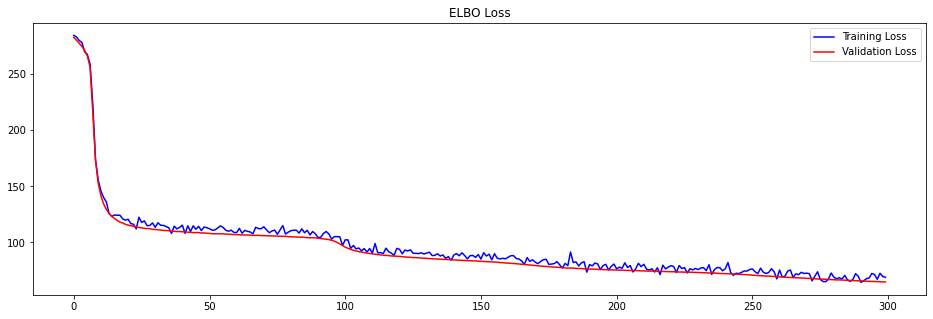

In [99]:
model = temp_mdl
fig,ax = plt.subplots(figsize=(16, 5))
ax.set_title('ELBO Loss')
ax.plot(model.total_loss,color='b',label='Training Loss')
ax.plot(model.val_loss,color='r',label='Validation Loss')
# plt.xlim([1490, 1500])
ax.legend(fontsize=10);

In [100]:
print('Model Min Trn Loss: ' + str(min(model.total_loss)))
print('Model Min Val Loss: ' + str(min(model.val_loss).numpy()))
print('Model Min Epoch (Val Loss): ' + str(np.argmin(np.array(model.val_loss))))
print('Model Embedded Mov Avg Var: ' + str(model.ema_mu.detach().numpy()))
print('Model Embedded Mov Avg SD: ' + str(model.ema_std.detach().numpy()))

Model Min Trn Loss: 64.31713
Model Min Val Loss: 64.77948
Model Min Epoch (Val Loss): 299
Model Embedded Mov Avg Var: 0.00045568473
Model Embedded Mov Avg SD: 0.95596623


In [102]:
#print('Dense Layers: ' + str(model.dense_layers))
print('Embedding Dim: ' + str(model.embedding_dim))
print('Compress Dim: ' + str(model.compress_dims))
print('Decompress Dim: ' + str(model.decompress_dims))
print('Log Frequency: ' + str(model.log_frequency))
print('L2 scale: ' + str(model.l2scale))
print('Batch Size: ' + str(model.batch_size))
print('Epochs: ' + str(model.epochs))
print('LR: ' + str(model.lr))
print('Loss factor: ' + str(model.loss_factor))
print('Conditional Generator Encoder: ' + str(model.cond_gen_encoder))
print('Conditional Generator Latent: ' + str(model.cond_gen_latent))

Embedding Dim: 128
Compress Dim: [128 128]
Decompress Dim: [128 128]
Log Frequency: True
L2 scale: 1e-05
Batch Size: 500
Epochs: 300
LR: 1e-05
Loss factor: 1
Conditional Generator Encoder: True
Conditional Generator Latent: True
